In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 1.0
lr = 2e-4
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999
batch_size = 256
epochs = 100
plot_every = 10

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)
        self.linear2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)
        self.linear3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)
        self.linear4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input):
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))
        generated = self.tanh(self.linear4(hidden3)).view(input.shape [0], 1, 28, 28)
        return generated

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        hidden1 = self.leaky_relu(self.linear1(input))
        hidden2 = self.leaky_relu(self.linear2(hidden1))
        classified = self.sigmoid(self.linear3(hidden2))
        return classified

In [ ]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

In [ ]:

train_dataset, test_dataset = mnist(train_size, transform)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

In [ ]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate (imgs):
        ax[i].imshow(im[0])
    plt.show()

In [ ]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()
            
        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

  0%|          | 0/100 [00:00<?, ?it/s]

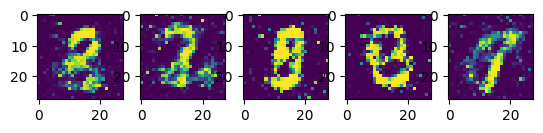

  5%|▌         | 5/100 [19:41<6:10:16, 233.85s/it, generator loss:=1.19, discriminator loss:=0.534]

In [ ]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)